In [152]:
import os
import sys
import pickle
import numpy as np

# sys.path.append('/n/home04/aboesky/berger/Weird_Galaxies')
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import astropy.units as u

from astropy.io import ascii
from astropy.table import vstack
from astropy.coordinates import SkyCoord

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_curve

plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

# Load data

In [35]:
# BTS
bts_hosts = ascii.read('/Users/adamboesky/Research/ay98/clean_data/bts_hosts.ecsv')

# YSE
yse_hosts = ascii.read('/Users/adamboesky/Research/ay98/clean_data/yse_hosts.ecsv')

# Combine
sn_tab = vstack((bts_hosts, yse_hosts))
sn_tab

objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,rKronMagErr_3pi,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,ZTFID
str18,str12,str12,str1,str7,str7,str7,str7,str7,str12,str12,str12,str12,str12,str10,float64,float64,str14,float64,str12
126681757766820931,175.77662082,15.56701789,1,16.0256,15.2881,14.9533,14.7114,14.5005,0.002978,0.001497,0.001272,0.001197,0.002235,0.1110298,175.77654166666665,15.56713888888889,--,--,--
148231465149294617,146.51493972,33.52836114,1,18.2387,17.9746,17.875,17.8532,17.7821,0.004157,0.004871,0.004281,0.014407,0.019814,0.021125,146.51479166666667,33.52825,SN II,0.038,ZTF18aacemcn
153731349546771375,134.95471695,38.10897029,1,18.7478,19.0585,18.6466,18.8301,18.6221,0.006392,0.009475,0.004919,0.017235,0.038667,0.01741071,134.95466666666664,38.10905555555556,SN II,0.07247,ZTF18aacnlxz
169101206490177628,120.64903126,50.9224606,1,16.5325,15.6522,15.2551,15.0064,14.7582,0.002335,0.002128,0.000867,0.001623,0.003512,0.07590476,120.64895833333333,50.92252777777777,SN Ia,0.05295,ZTF18aadlaxo
159661026075384557,102.60753619,43.05326583,1,nan,14.2309,13.166,12.9816,12.8047,nan,0.000836,0.000408,0.001003,0.001687,0.1546488,102.60754166666663,43.05322222222222,SN IIn,0.01885,ZTF18aadmssd
146001295340652041,129.53408241,31.66789412,1,17.2694,16.9697,16.8672,16.8232,16.7636,0.004272,0.003413,0.005182,0.005542,0.014564,0.00466667,129.53395833333332,31.667916666666667,SN II,0.03057,ZTF18aadsuxd
160090985073071380,98.50726462,43.40895049,1,17.7127,16.8614,16.3023,16.0124,15.8248,0.005224,0.003569,0.001682,0.003451,0.005626,0.02679167,98.50770833333333,43.40902777777777,SN Ia,0.064,ZTF18aadxnul
159981068237030321,106.82370726,43.31640285,1,16.9512,16.1689,15.6894,15.5194,15.3639,0.003268,0.002049,0.001297,0.002374,0.005479,0.02479167,106.823625,43.31641666666666,SN Ia,0.05,ZTF18aadzfso
135811154938631883,115.49382081,23.17596697,1,15.7987,nan,nan,nan,nan,0.001466,nan,nan,nan,nan,0.2847917,115.49429166666664,23.176472222222223,SN Ia,0.043,ZTF18aaeqjmc


In [63]:
# Drop rows without SN classification
sn_tab = sn_tab[~sn_tab['sn_class'].mask]
sn_tab

# Add the angular separation between SN and host galaxy in arcseconds
sn_coords = SkyCoord(ra=sn_tab['SN_ra'], dec=sn_tab['SN_dec'], unit='deg')
host_coords = SkyCoord(ra=sn_tab['raStack_3pi'], dec=sn_tab['decStack_3pi'], unit='deg')
sn_tab['sep_arcsec'] = sn_coords.separation(host_coords).arcsec

sn_df = sn_tab.to_pandas()

In [64]:
classification_groups = [['ia'], ['ib', 'ic'], ['slsn'], ['iin'], ['ii', 'iip', 'ii p', 'iil', 'ii l']]

def add_sn_class_cols(df: pd.DataFrame) -> pd.DataFrame:
    # Ia or other
    ia_mask = np.char.find(np.char.lower(np.array([str(item) for item in df['sn_class']], dtype=str)), 'ia') != -1
    df['sn_class_binary'] = ia_mask.astype(int)

    # Ia, II, or other
    # Conditions to check for 'ii' or 'ia' in a case-insensitive manner
    condition_ii = np.vectorize(lambda s: 'ii' in s.lower())
    condition_ia = np.vectorize(lambda s: 'ia' in s.lower())

    # Apply conditions and choices to the string array
    df['sn_class_tertiary'] = np.where(condition_ia(df['sn_class']), 0, np.where(condition_ii(df['sn_class']), 1, 2))

    # Your classification groups
    def add_category_id_column(my_df, classification_groups):
        # Convert classification groups to lowercase and assign unique integers to each category
        lowercase_groups = {cls.lower(): i for i, group in enumerate(classification_groups) for cls in group}

        # Function to get the category id for a supernova class
        def get_category_id(sn_class_list):
            for sn_class in sn_class_list:
                sn_class_lower = sn_class.lower()
                for group, group_id in lowercase_groups.items():
                    if group in sn_class_lower:
                        return group_id
            return np.max(list(lowercase_groups.values())) + 1  # Return a default id if no category is found

        # Add 'category_id' column to the DataFrame
        my_df['sn_class_cat'] = my_df['sn_class'].apply(lambda x: get_category_id(x.split(',')))

        return my_df

    # Apply the function to the DataFrame
    df = add_category_id_column(df, classification_groups)
    for idx, snt in enumerate(('ia', 'ib/c', 'slsn', 'iin', 'ii (p/l)', 'other')):
        print(f'The data are {np.round(len(df[df["sn_class_cat"] == idx]) / len(df) * 100, 2)}% type {snt} with n = {len(df[df["sn_class_cat"] == idx])}')

    return df

In [65]:
sn_df = add_sn_class_cols(sn_df)
sn_df

The data are 75.15% type ia with n = 3683
The data are 7.37% type ib/c with n = 361
The data are 0.65% type slsn with n = 32
The data are 2.37% type iin with n = 116
The data are 13.94% type ii (p/l) with n = 683
The data are 0.53% type other with n = 26


,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,...,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,ZTFID,sep_arcsec,sn_class_binary,sn_class_tertiary,sn_class_cat
0,148231465149294617,146.51493972,33.52836114,1,18.2387,17.9746,17.875,17.8532,17.7821,0.004157,...,0.021125,146.514792,33.528250,SN II,0.03800,ZTF18aacemcn,0.597908,0,1,4
1,153731349546771375,134.95471695,38.10897029,1,18.7478,19.0585,18.6466,18.8301,18.6221,0.006392,...,0.01741071,134.954667,38.109056,SN II,0.07247,ZTF18aacnlxz,0.338392,0,1,4
2,169101206490177628,120.64903126,50.9224606,1,16.5325,15.6522,15.2551,15.0064,14.7582,0.002335,...,0.07590476,120.648958,50.922528,SN Ia,0.05295,ZTF18aadlaxo,0.293045,1,0,0
3,159661026075384557,102.60753619,43.05326583,1,nan,14.2309,13.166,12.9816,12.8047,nan,...,0.1546488,102.607542,43.053222,SN IIn,0.01885,ZTF18aadmssd,0.157648,0,1,3
4,146001295340652041,129.53408241,31.66789412,1,17.2694,16.9697,16.8672,16.8232,16.7636,0.004272,...,0.00466667,129.533958,31.667917,SN II,0.03057,ZTF18aadsuxd,0.388737,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4896,91140220649260935,22.06491056,-14.04954556,1,18.0565,17.3057,16.8992,16.6476,16.4545,0.005967,...,0.00175,22.065450,-14.051486,SNIa-norm,0.10400,NaN,7.235150,1,0,0
4897,122193229064908516,322.90645396,11.83166024,1,14.7039,13.9191,13.5128,13.2656,13.0388,0.001149,...,0.1600238,322.906997,11.832946,SNIa-norm,0.02500,NaN,5.008624,1,0,0
4898,119713173483364644,317.34832855,9.76180289,1,16.943,16.4661,16.0112,15.9251,15.7482,0.004014,...,0.02083333,317.348935,9.760885,SNIbn,0.08000,NaN,3.943161,0,2,1
4899,158721402117007558,140.21168731,42.27242849,1,16.4714,16.0417,15.8206,15.6633,15.5445,0.00294,...,0.04576786,140.211901,42.272211,SNIa-norm,0.03300,NaN,0.968020,1,0,0


In [66]:
sn_df = sn_df[sn_df['sn_class_cat'] != 5]
sn_df

,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,...,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,ZTFID,sep_arcsec,sn_class_binary,sn_class_tertiary,sn_class_cat
0,148231465149294617,146.51493972,33.52836114,1,18.2387,17.9746,17.875,17.8532,17.7821,0.004157,...,0.021125,146.514792,33.528250,SN II,0.03800,ZTF18aacemcn,0.597908,0,1,4
1,153731349546771375,134.95471695,38.10897029,1,18.7478,19.0585,18.6466,18.8301,18.6221,0.006392,...,0.01741071,134.954667,38.109056,SN II,0.07247,ZTF18aacnlxz,0.338392,0,1,4
2,169101206490177628,120.64903126,50.9224606,1,16.5325,15.6522,15.2551,15.0064,14.7582,0.002335,...,0.07590476,120.648958,50.922528,SN Ia,0.05295,ZTF18aadlaxo,0.293045,1,0,0
3,159661026075384557,102.60753619,43.05326583,1,nan,14.2309,13.166,12.9816,12.8047,nan,...,0.1546488,102.607542,43.053222,SN IIn,0.01885,ZTF18aadmssd,0.157648,0,1,3
4,146001295340652041,129.53408241,31.66789412,1,17.2694,16.9697,16.8672,16.8232,16.7636,0.004272,...,0.00466667,129.533958,31.667917,SN II,0.03057,ZTF18aadsuxd,0.388737,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4896,91140220649260935,22.06491056,-14.04954556,1,18.0565,17.3057,16.8992,16.6476,16.4545,0.005967,...,0.00175,22.065450,-14.051486,SNIa-norm,0.10400,NaN,7.235150,1,0,0
4897,122193229064908516,322.90645396,11.83166024,1,14.7039,13.9191,13.5128,13.2656,13.0388,0.001149,...,0.1600238,322.906997,11.832946,SNIa-norm,0.02500,NaN,5.008624,1,0,0
4898,119713173483364644,317.34832855,9.76180289,1,16.943,16.4661,16.0112,15.9251,15.7482,0.004014,...,0.02083333,317.348935,9.760885,SNIbn,0.08000,NaN,3.943161,0,2,1
4899,158721402117007558,140.21168731,42.27242849,1,16.4714,16.0417,15.8206,15.6633,15.5445,0.00294,...,0.04576786,140.211901,42.272211,SNIa-norm,0.03300,NaN,0.968020,1,0,0


# Classify stuff

In [67]:
import sys

sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper')

from preprocessing.preprocessing import ab_mag_to_flux

ab_magerr_to_ferr = lambda sigma_m, f: np.abs(f * np.log(10) * (sigma_m / 2.5))  # transformation on the error of a magnitude turned into flux

from SPLASH.pipeline import Splash_Pipeline

In [113]:
# Get the grizy values
grizy_keys = ['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi', 'yKronMag_3pi']
grizy_err_keys = ['gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi', 'zKronMagErr_3pi', 'yKronMagErr_3pi']

# Get the data
grizy = ab_mag_to_flux(sn_df[grizy_keys].to_numpy(dtype=np.float32))
grizy_err = ab_magerr_to_ferr(sn_df[grizy_err_keys].to_numpy(dtype=np.float32), grizy)
redshift = sn_df['sn_redshift'].to_numpy(dtype=np.float32)
seps = sn_df['sep_arcsec'].to_numpy(dtype=np.float32)

# Infer the classes
pipeline = Splash_Pipeline()
inferred_classes = pipeline.infer_classes(
    grizy=grizy,
    grizy_err=grizy_err,
    redshift=redshift,
    angular_sep=seps,
)
inferred_probs = pipeline.infer_probs(
    grizy=grizy,
    grizy_err=grizy_err,
    redshift=redshift,
    angular_sep=seps,
)
inferred_props, inferred_properrs = pipeline.infer_host_properties(
    grizy=grizy,
    grizy_err=grizy_err,
    redshift=redshift,
)

# Drop the out-of-bounds classes
ood_mask = inferred_classes == -1
print(f'There are {np.sum(ood_mask)} out-of-bounds SNe')
inferred_classes = inferred_classes[~ood_mask]
inferred_probs = inferred_probs[~ood_mask]
inferred_props = inferred_props[~ood_mask]
inferred_properrs = inferred_properrs[~ood_mask]
sn_df = sn_df[~ood_mask]

There are 0 out-of-bounds SNe


In [114]:
binary_inferred_probs = np.vstack((inferred_probs[:, 0], 1 - inferred_probs[:, 0])).T
binary_inferred_probs

array([[0.459, 0.541],
       [0.464, 0.536],
       [0.992, 0.008],
       ...,
       [0.89 , 0.11 ],
       [0.312, 0.688],
       [0.174, 0.826]])

In [115]:
sn_df

,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,...,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,ZTFID,sep_arcsec,sn_class_binary,sn_class_tertiary,sn_class_cat
0,148231465149294617,146.51493972,33.52836114,1,18.2387,17.9746,17.875,17.8532,17.7821,0.004157,...,0.021125,146.514792,33.528250,SN II,0.03800,ZTF18aacemcn,0.597908,0,1,4
1,153731349546771375,134.95471695,38.10897029,1,18.7478,19.0585,18.6466,18.8301,18.6221,0.006392,...,0.01741071,134.954667,38.109056,SN II,0.07247,ZTF18aacnlxz,0.338392,0,1,4
2,169101206490177628,120.64903126,50.9224606,1,16.5325,15.6522,15.2551,15.0064,14.7582,0.002335,...,0.07590476,120.648958,50.922528,SN Ia,0.05295,ZTF18aadlaxo,0.293045,1,0,0
3,159661026075384557,102.60753619,43.05326583,1,nan,14.2309,13.166,12.9816,12.8047,nan,...,0.1546488,102.607542,43.053222,SN IIn,0.01885,ZTF18aadmssd,0.157648,0,1,3
4,146001295340652041,129.53408241,31.66789412,1,17.2694,16.9697,16.8672,16.8232,16.7636,0.004272,...,0.00466667,129.533958,31.667917,SN II,0.03057,ZTF18aadsuxd,0.388737,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4896,91140220649260935,22.06491056,-14.04954556,1,18.0565,17.3057,16.8992,16.6476,16.4545,0.005967,...,0.00175,22.065450,-14.051486,SNIa-norm,0.10400,NaN,7.235150,1,0,0
4897,122193229064908516,322.90645396,11.83166024,1,14.7039,13.9191,13.5128,13.2656,13.0388,0.001149,...,0.1600238,322.906997,11.832946,SNIa-norm,0.02500,NaN,5.008624,1,0,0
4898,119713173483364644,317.34832855,9.76180289,1,16.943,16.4661,16.0112,15.9251,15.7482,0.004014,...,0.02083333,317.348935,9.760885,SNIbn,0.08000,NaN,3.943161,0,2,1
4899,158721402117007558,140.21168731,42.27242849,1,16.4714,16.0417,15.8206,15.6633,15.5445,0.00294,...,0.04576786,140.211901,42.272211,SNIa-norm,0.03300,NaN,0.968020,1,0,0


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_37987/1481873616.py:9: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(recall, precision, color='#0084DD', label='Ia')
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_37987/1481873616.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


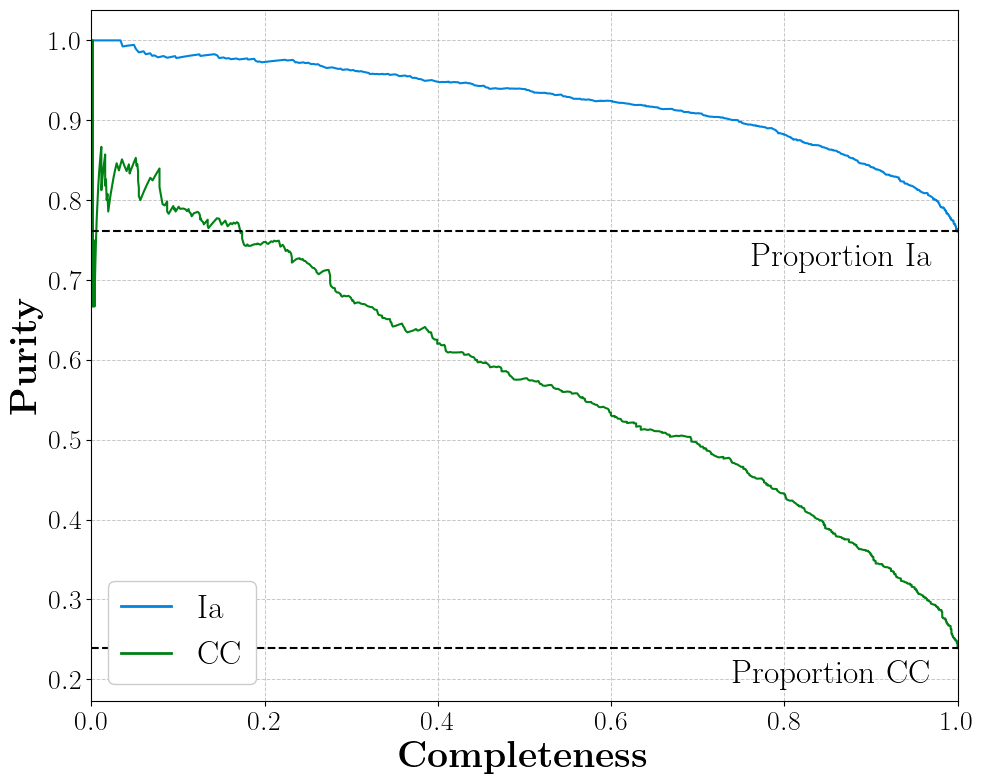

In [150]:
fs=24

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(sn_df['sn_class_binary'], binary_inferred_probs[:, 0], pos_label=1)
precision_0, recall_0, _ = precision_recall_curve(sn_df['sn_class_binary'], binary_inferred_probs[:, 1], pos_label=0)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='#0084DD', label='Ia')
plt.plot(recall_0, precision_0, color='#008114', label='CC')
frac_cc = (sn_df['sn_class_binary']==0).mean()
frac_ia = (sn_df['sn_class_binary']==1).mean()
plt.axhline(y=frac_cc, color='k', linestyle='--')
plt.axhline(y=frac_ia, color='k', linestyle='--')
plt.text(0.97, frac_cc-0.015, 'Proportion CC', horizontalalignment='right', verticalalignment='top', fontsize=fs)
plt.text(0.97, frac_ia-0.015, 'Proportion Ia', horizontalalignment='right', verticalalignment='top', fontsize=fs)

plt.xlabel(r'\bf{Completeness}', fontsize=fs+3)
plt.ylabel(r'\bf{Purity}', fontsize=fs+3)

leg = plt.legend(fontsize=fs, loc='lower left', framealpha=1, handlelength=1.5)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

plt.xlim(0, 1)
plt.ylim(bottom=0.173)

plt.tick_params(axis='both', which='major', labelsize=fs-4)

plt.tight_layout()

plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Final_Paper/Figures/purity_v_completeness_bts_yse.pdf', bbox_inches='tight')

plt.show()

F1 Score: 0.298


/Users/adamboesky/opt/anaconda3/envs/ay98_newskl/lib/python3.12/site-packages/seaborn/matrix.py:456: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/Users/adamboesky/opt/anaconda3/envs/ay98_newskl/lib/python3.12/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


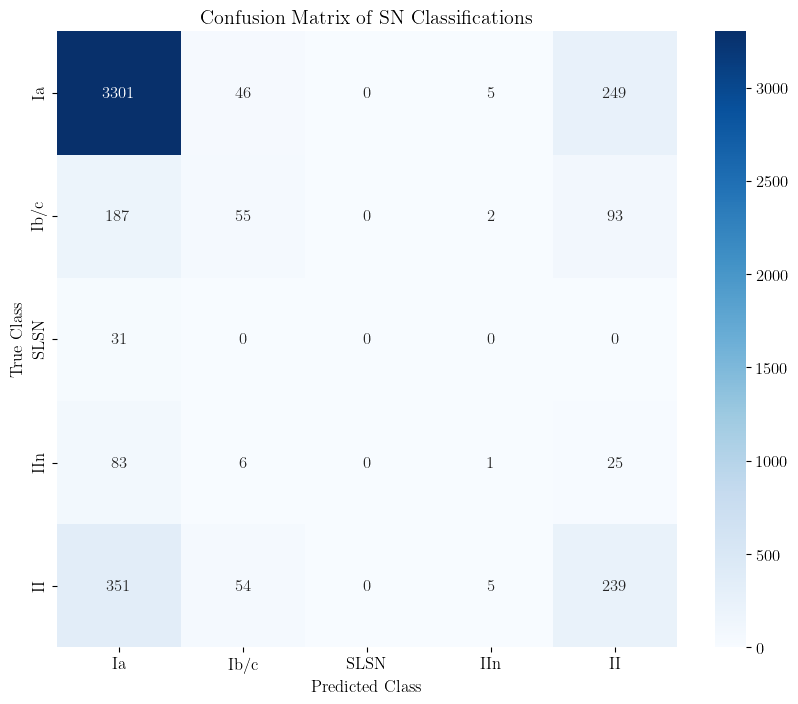

In [109]:
# Create confusion matrix
cm = confusion_matrix(sn_df['sn_class_cat'], inferred_classes)

# Calculate and print F1 score
f1 = f1_score(sn_df['sn_class_cat'], inferred_classes, average='macro')
print(f'F1 Score: {f1:.3f}')

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('True Class') 
plt.title('Confusion Matrix of SN Classifications')

# Add class labels
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II']
plt.xticks(np.arange(len(class_labels))+0.5, class_labels)
plt.yticks(np.arange(len(class_labels))+0.5, class_labels)

plt.show()

# F1 scores

In [159]:
# Logic out the three-class inferences
inferred_3_classes = inferred_classes.copy()
inferred_3_classes[inferred_3_classes == 2] = 1
inferred_3_classes[(inferred_3_classes == 3) | (inferred_3_classes == 4)] = 2

# Logic out the binary inferences
inferred_2_classes = inferred_3_classes.copy()
inferred_2_classes[inferred_2_classes == 2] = 1
inferred_2_classes = np.abs(inferred_2_classes - 1)

# Get the f1 scores and accuracies
f1_scores = {}
f1_scores_3_class = {}
f1_scores_binary = {}
for avg in ['weighted', 'macro']:
    f1_scores[avg] = f1_score(sn_df['sn_class_cat'], inferred_classes, average=avg)
    f1_scores_3_class[avg] = f1_score(sn_df['sn_class_tertiary'].replace({2:1, 3:2, 4:2}), inferred_3_classes, average=avg)
    f1_scores_binary[avg] = f1_score(sn_df['sn_class_binary'], inferred_2_classes, average=avg)

# Get accuracies for all classification schemes
accuracies = {}
accuracies['5-class'] = accuracy_score(sn_df['sn_class_cat'], inferred_classes)
accuracies['3-class'] = accuracy_score(sn_df['sn_class_tertiary'].replace({2:1, 3:2, 4:2}), inferred_3_classes)
accuracies['binary'] = accuracy_score(sn_df['sn_class_binary'], inferred_2_classes)

# Print all metrics
print("5-class classification:")
print(f"\tAccuracy: {accuracies['5-class']:.3f}")
print(f"\tWeighted F1: {f1_scores['weighted']:.3f}")
print(f"\tMacro F1: {f1_scores['macro']:.3f}\n")

print("3-class classification:")
print(f"\tAccuracy: {accuracies['3-class']:.3f}")
print(f"\tWeighted F1: {f1_scores_3_class['weighted']:.3f}")
print(f"\tMacro F1: {f1_scores_3_class['macro']:.3f}\n")

print("Binary classification:")
print(f"\tAccuracy: {accuracies['binary']:.3f}")
print(f"\tWeighted F1: {f1_scores_binary['weighted']:.3f}")
print(f"\tMacro F1: {f1_scores_binary['macro']:.3f}")


5-class classification:
	Accuracy: 0.760
	Weighted F1: 0.733
	Macro F1: 0.298

3-class classification:
	Accuracy: 0.722
	Weighted F1: 0.707
	Macro F1: 0.351

Binary classification:
	Accuracy: 0.799
	Weighted F1: 0.785
	Macro F1: 0.688


# Making cuts on host properties

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_37987/1608376158.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(inferred_props[:, 0], bins=50)


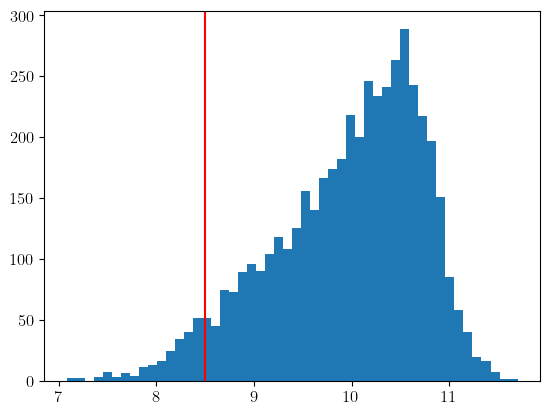

In [130]:
plt.hist(inferred_props[:, 0], bins=50)
plt.axvline(8.5, color='red')

In [162]:
# A mask to cut the population on host properties
cut_mask = inferred_props[:, 0] < 8.5

# Print the results
print(f'log(M_*) < 8.5 (n={np.sum(cut_mask)}):')
inferred_prop_ia = np.mean((inferred_classes == 0)[cut_mask])
true_prop_ia = np.mean((sn_df['sn_class_binary'] == 1)[cut_mask])
print(f'\tInferred prop CC: {1 - inferred_prop_ia:.3f}\n\tTrue prop CC: {1 - true_prop_ia:.3f}')

print(f'\nlog(M_8) >= 8.5 (n={np.sum(~cut_mask)}):')
inferred_prop_ia = np.mean((inferred_classes == 0)[~cut_mask])
true_prop_ia = np.mean((sn_df['sn_class_binary'] == 1)[~cut_mask])
print(f'\tInferred prop CC: {1 - inferred_prop_ia:.3f}\n\tTrue prop Ia: {1 - true_prop_ia:.3f}')

log(M_*) < 8.5 (n=235):
	Inferred prop CC: 0.353
	True prop CC: 0.404

log(M_8) >= 8.5 (n=4498):
	Inferred prop CC: 0.155
	True prop Ia: 0.231
